# Data exploration


In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
import IPython.display as ipd
import os
import torch
from scipy.io import wavfile
import torchaudio
from audiosep.io import load_audio_tensor

In [ ]:
idx = 1
root = "../data/train_small/"

example_dirs = sorted(
    d for d in os.listdir(root)
    if os.path.isdir(os.path.join(root, d))
)

print(f"Nombre d'exemples dans le jeu de données : {len(example_dirs)}")

folder = example_dirs[idx]
folder_path = os.path.join(root, folder)

# filenames
mix_file = [f for f in os.listdir(folder_path) if f.startswith("mix")][0]
mix_path   = os.path.join(folder_path, mix_file)
voice_path = os.path.join(folder_path, "voice.wav")
noise_path = os.path.join(folder_path, "noise.wav")

mix, sr_mix  = load_audio_tensor(mix_path)
voice, sr_voice = load_audio_tensor(voice_path)
noise, sr_noise = load_audio_tensor(noise_path)

# Normalize mix to have same peak as voice
eps = 1e-12
voice_peak = torch.max(torch.abs(voice)) + eps
mix_peak = torch.max(torch.abs(mix)) + eps
mix = mix * (voice_peak / mix_peak)   

# Listen to each signal in the notebook
import IPython.display as ipd
print(f"Mix {mix_file}:")
ipd.display(ipd.Audio(mix, rate=sr_mix))
print(f"Voice {voice_path}:")
ipd.display(ipd.Audio(voice, rate=sr_voice))
print(f"Noise {noise_path}:")
ipd.display(ipd.Audio(noise, rate=sr_noise))  

Nombre d'exemples dans le jeu de données : 50
Mix mix_snr_0.wav:


Voice ../data/train_small/0001/voice.wav:


Noise ../data/train_small/0001/noise.wav:


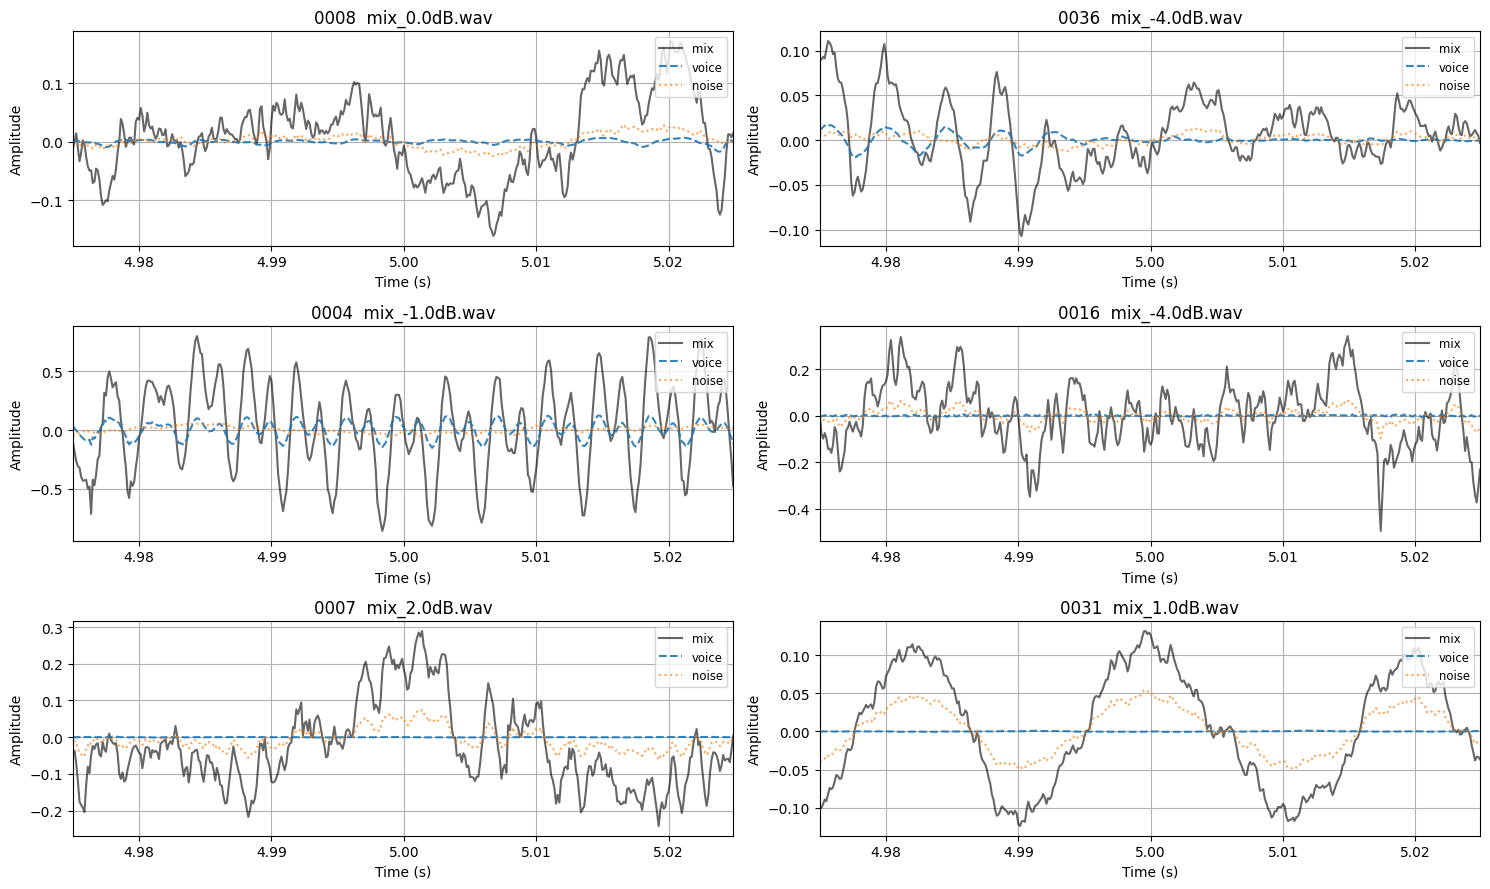

In [ ]:
import os
import random
import re
import numpy as np
import matplotlib.pyplot as plt
from audiosep.io import load_audio_tensor
import torch

root = "../data/train_small/"
n_plots = 6
win_sec = 0.05  # window length in seconds to plot

example_dirs = sorted(d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d)))
if len(example_dirs) < n_plots:
    raise RuntimeError("Not enough examples in dataset")

random.seed(1)
sel = random.sample(example_dirs, n_plots)

def _extract_snr_label(filename: str) -> str:
    m = re.search(r'(-?\d+(?:\.\d+)?)\s*[dD][bB]', filename)
    if m:
        return f"{float(m.group(1)):.1f}dB"
    m2 = re.search(r'(?:(?:^|[_\-\.\s]))(-?\d+(?:\.\d+)?)(?=$|[_\-\.\s])', filename)
    if m2:
        return f"{float(m2.group(1)):.1f}dB"
    return "n/a"

def _load_numpy(path):
    sig, sr = load_audio_tensor(path)
    # support torch tensor or numpy array, ensure 1D numpy
    if isinstance(sig, torch.Tensor):
        sig = sig.detach().cpu().numpy()
    sig = np.asarray(sig)
    if sig.ndim > 1:
        sig = sig[0]
    return sig, sr

# Preload data (one IO per file)
items = []
for folder in sel:
    fp = os.path.join(root, folder)
    mix_file = [f for f in os.listdir(fp) if f.startswith("mix")][0]
    mix_path = os.path.join(fp, mix_file)
    voice_path = os.path.join(fp, "voice.wav")
    noise_path = os.path.join(fp, "noise.wav")
    mix, sr_mix = _load_numpy(mix_path)
    voice, _ = _load_numpy(voice_path)
    noise, _ = _load_numpy(noise_path)
    items.append((folder, mix_file, mix, voice, noise, sr_mix))

# Plot grid
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
axes = axes.ravel()

for ax, (folder, mix_file, mix, voice, noise, sr_mix) in zip(axes, items):
    # align lengths
    min_len = min(len(mix), len(voice), len(noise))
    mix = mix[:min_len]
    voice = voice[:min_len]
    noise = noise[:min_len]
    
    # normalize
    # mix = mix / (np.max(np.abs(mix)) + eps)
    # voice = voice / (np.max(np.abs(voice)) + eps)
    # noise = noise / (np.max(np.abs(noise)) + eps)
    
    # def rms(x):
    #     return np.sqrt(np.mean(x**2) + eps)

    # mix = mix / rms(mix)
    # voice = voice / rms(voice)
    # noise = noise / rms(noise)
    
    # Normalisation
    # mix = mix / (np.max(np.abs(mix)) + eps)
    # voice = voice / (np.max(np.abs(voice)) + eps)
    # noise = noise / (np.max(np.abs(noise)) + eps)
    
    # normalize by mix peak (preserves mix = voice + noise)
    gain = 1.0 / (mix.abs().max() + 1e-8)
    mix   = mix * gain
    voice = voice * gain
    noise = noise * gain
        

    # snr label from filename
    snr_label = _extract_snr_label(mix_file)
    if snr_label == "n/a":
        # fallback compute
        voice_power = np.mean(voice.astype(np.float64) ** 2)
        noise_power = np.mean(noise.astype(np.float64) ** 2)
        if noise_power <= eps:
            snr_label = "inf"
        else:
            snr_db = 10.0 * np.log10((voice_power + eps) / (noise_power + eps))
            snr_label = f"{snr_db:.1f}dB"

    # choose central window
    win_len = min(int(win_sec * sr_mix), min_len)
    start = max(0, (min_len - win_len) // 2)
    end = start + win_len
    t = np.arange(win_len) / sr_mix + start / sr_mix

    ax.plot(t, mix[start:end], label="mix", color="k", alpha=0.6)
    ax.plot(t, voice[start:end], label="voice", linestyle="--", alpha=0.9)
    ax.plot(t, noise[start:end], label="noise", linestyle=":", alpha=0.7)
    ax.set_title(f"{folder}  mix_{snr_label}.wav")
    ax.set_xlim(t[0], t[-1])
    # ax.set_ylim(-0.25, 0.25)
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()